In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
import pandas as pd

from stardist.utils import mask_to_categorical
from stardist.plot import render_label

plt.rcParams["figure.figsize"] = (15,15)
lbl_cmap = random_label_cmap()

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20

def plot_img_label(img, lbl, cls_dict, n_classes=2, img_title="image", lbl_title="label", cls_title="classes", **kwargs):
    c = mask_to_categorical(lbl, n_classes=n_classes, classes=cls_dict)
    res = np.zeros(lbl.shape, np.uint16)
    for i in range(1,c.shape[-1]):
        m = c[...,i]>0
        res[m] = i
    class_img = lbl_cmap_classes(res)
    class_img[...,:3][res==0] = 0 
    class_img[...,-1][res==0] = 1
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(25,15), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title)
    ac.imshow(class_img)
    ac.imshow(render_label(res, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8, cmap=lbl_cmap_classes))
    ac.set_title(cls_title)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac



2024-09-24 13:43:49.537555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 13:43:49.537687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 13:43:50.191796: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 13:43:50.846927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
X = sorted(glob('/mnt/towbin.data/shared/spsalmon/443 test/split_dataset/images/*.tiff'))
Y = sorted(glob('/mnt/towbin.data/shared/spsalmon/443 test/split_dataset/masks/*.tiff'))
classes = sorted(glob('/mnt/towbin.data/shared/spsalmon/443 test/split_dataset/classes/*.csv'))

print(len(classes))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
classes = [pd.read_csv(c) for c in classes]

# convert classes to dictionary
classes = [dict(zip(c['label'], c['class'])) for c in classes]

print(classes)

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
X = [x/np.max(x) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

assert len(X) > 1, "not enough training data"
print(f'number of images: {len(X)}, number_of masks {len(Y)}, number of classes: {len(classes)}')
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.25 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val, classes_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val], [classes[i] for i in ind_val]
X_trn, Y_trn, classes_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] , [classes[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

369
[{1: 2}, {1: 3, 2: 3, 3: 3, 4: 1, 5: 3, 6: 1, 7: 3, 8: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 1, 14: 1, 15: 2, 16: 3}, {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 2, 22: 1, 23: 1, 24: 1, 25: 3, 26: 1, 27: 1, 28: 1}, {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 3, 27: 2, 28: 2, 29: 1, 30: 1, 31: 1, 32: 3, 33: 1, 34: 1, 35: 2, 36: 2}, {1: 1, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1, 19: 1, 20: 2, 21: 1, 22: 1, 23: 1, 24: 2, 25: 2, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 2, 38: 2, 39: 1, 40: 1, 41: 1, 42: 2, 43: 2, 44: 1, 45: 1, 46: 2, 47: 2, 48: 2, 49: 2, 50: 1, 51: 2, 52: 1, 53: 1, 54: 1}, {1: 2, 2: 1, 3: 1, 4: 1, 5: 2, 6: 1, 7: 2, 8: 2, 9: 1, 10: 1, 11: 1, 12: 2, 1

100%|██████████| 369/369 [00:02<00:00, 150.48it/s]

number of images: 369, number_of masks 369, number of classes: 369
number of images: 369
- training:       277
- validation:      92


(<Axes: title={'center': 'image'}>,
 <Axes: title={'center': 'label'}>,
 <Axes: title={'center': 'classes'}>)

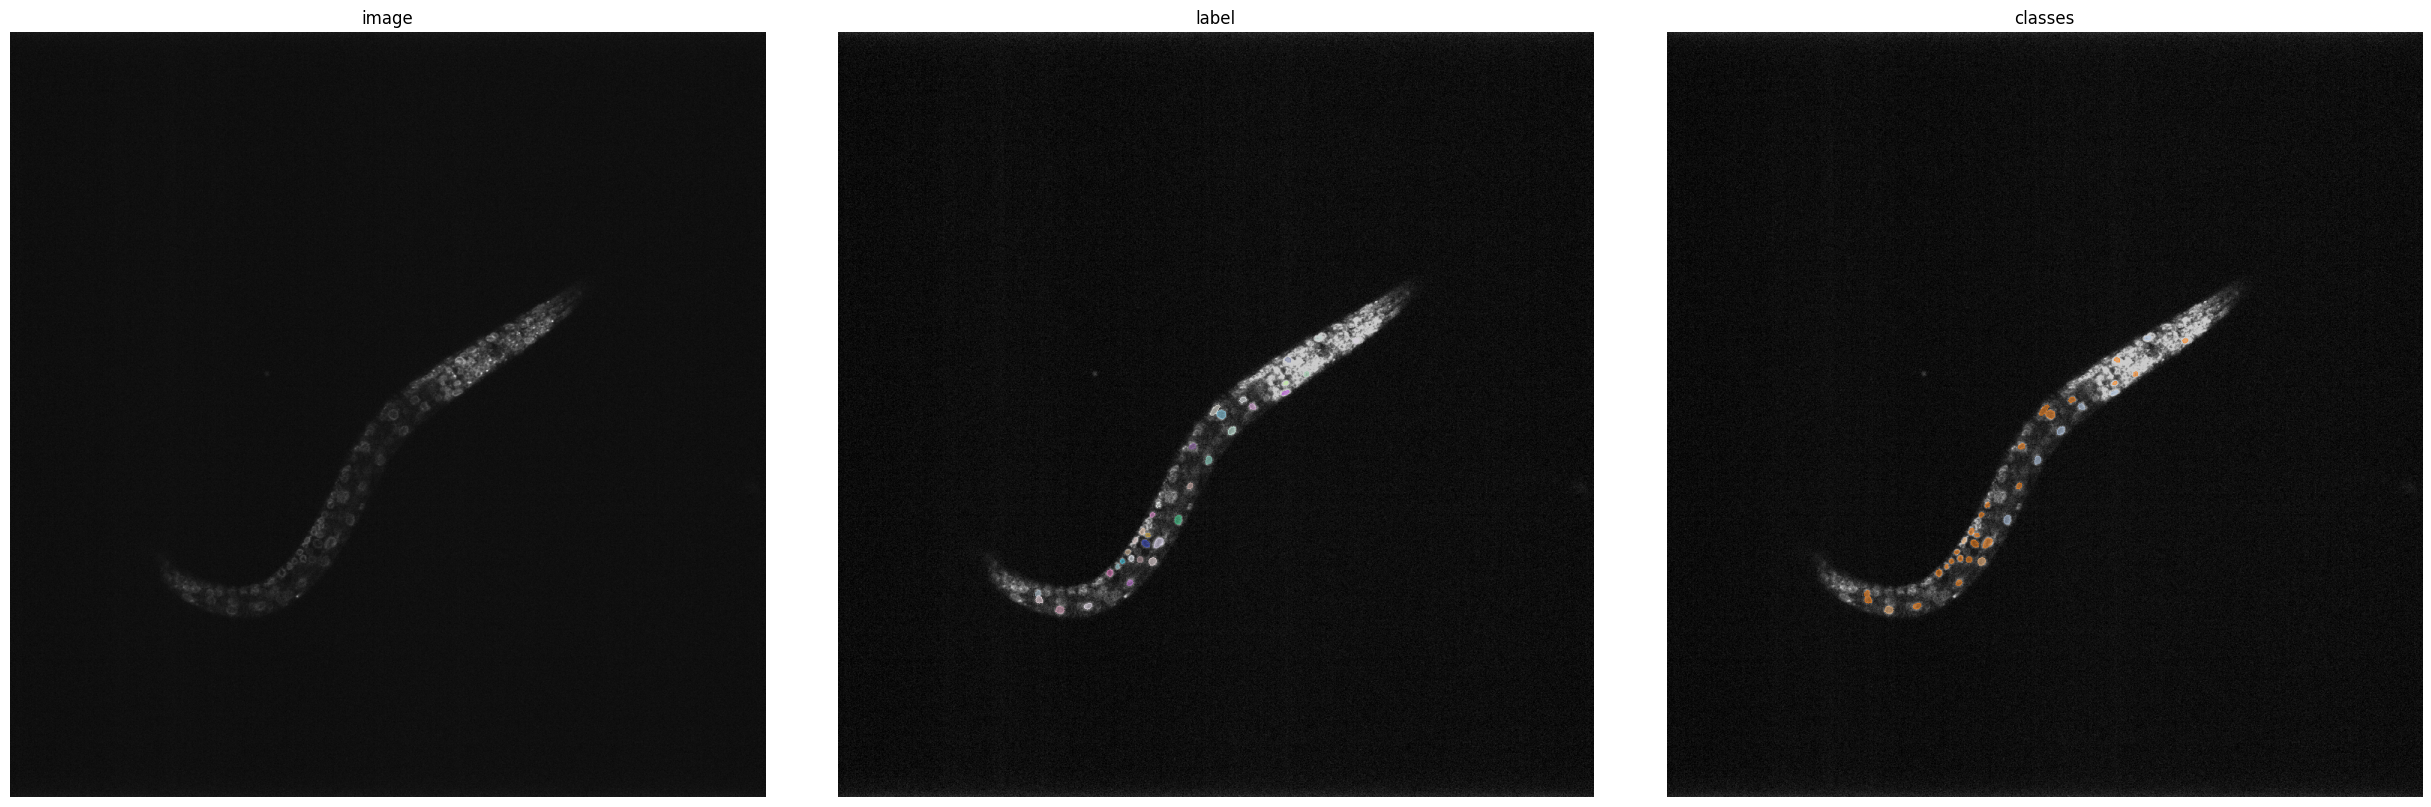

In [3]:
# randomly pick an index from validation data
# i = rng.randint(len(X_val))
i = 20
img, lbl, c = X_val[i], Y_val[i], classes_val[i]

plot_img_label(img, lbl, c, n_classes=3, img_title="image", lbl_title="label", cls_title="classes")


In [4]:
demo_model = False

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist_panoptic_no_annotation_small_grid', basedir='models')
None

labels, details = model.predict_instances(img)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.503078, nms_thresh=0.3.


In [5]:
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict

classes = class_from_res(details)

In [6]:
print(classes)

{1: 2, 2: 2, 3: 2, 4: 1, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 0, 31: 0}


(<Axes: title={'center': 'image'}>,
 <Axes: title={'center': 'label'}>,
 <Axes: title={'center': 'classes'}>)

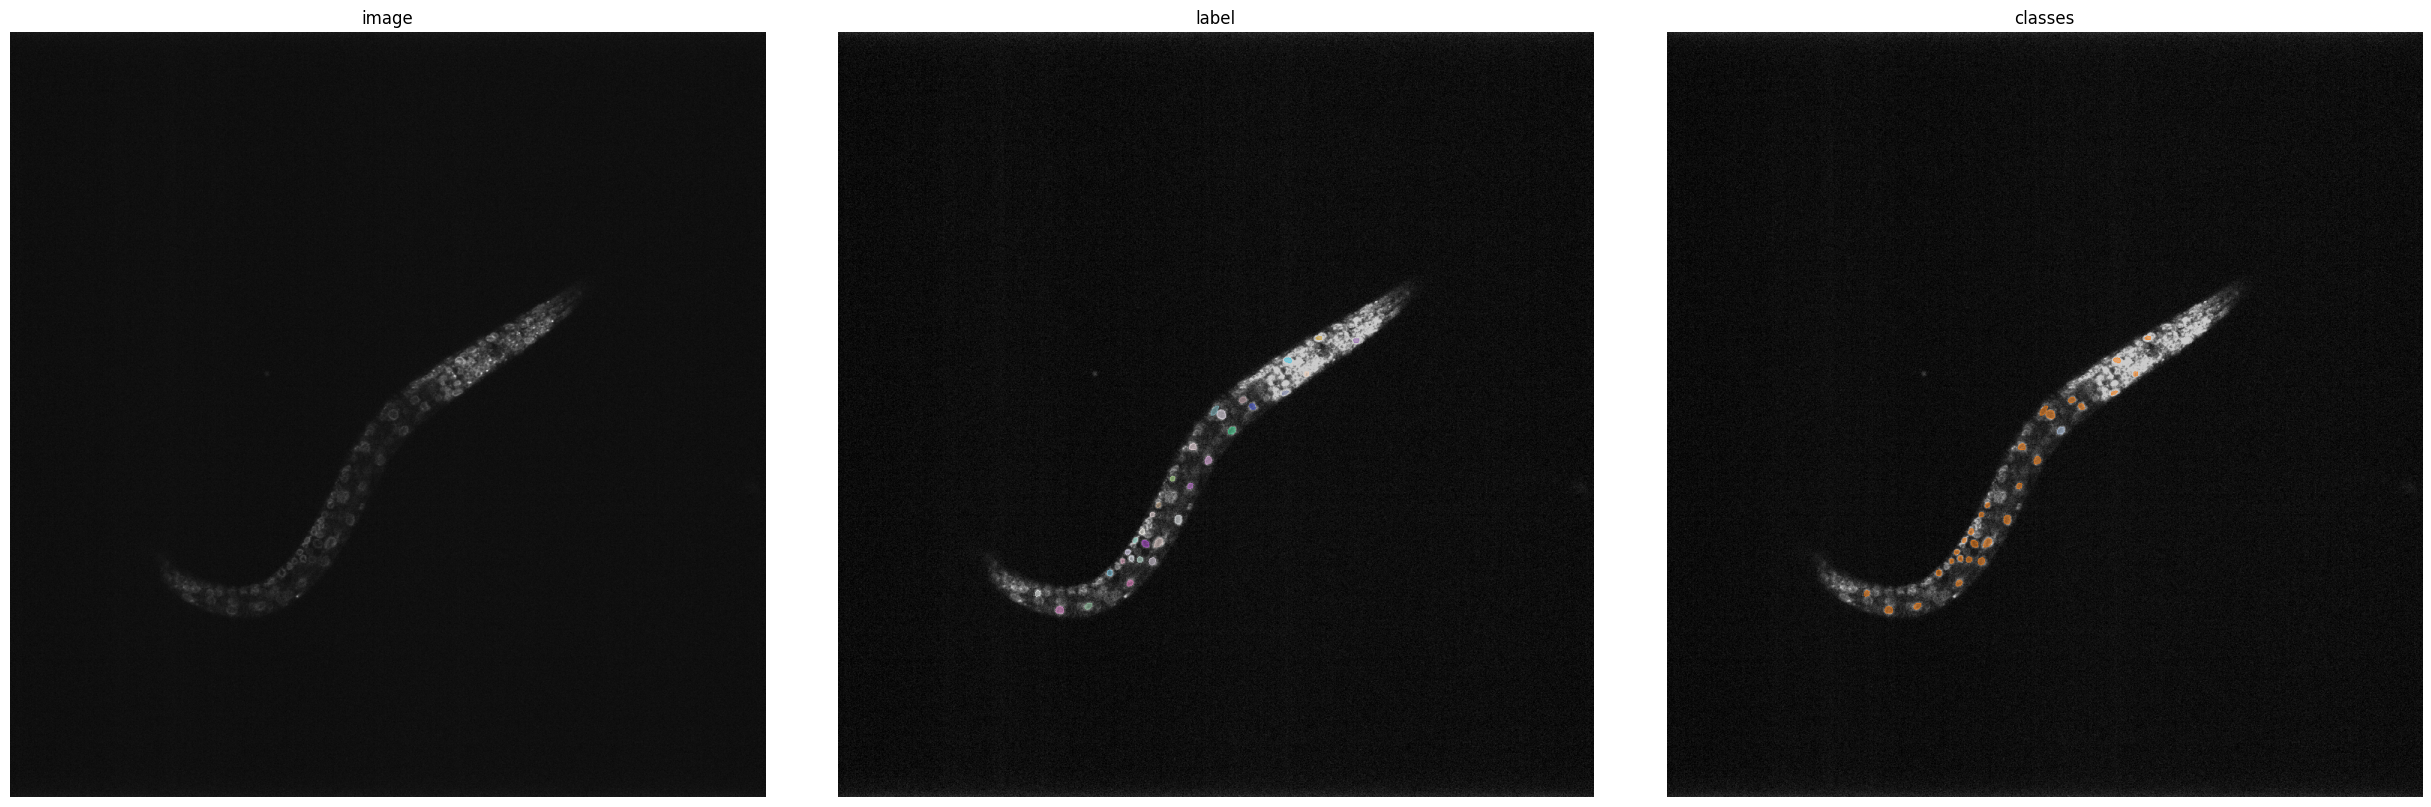

In [7]:
plot_img_label(img, labels, classes, n_classes=3, img_title="image", lbl_title="label", cls_title="classes")

In [8]:
from skimage.filters import sato, hessian, otsu

filtered_img = hessian(img, black_ridges=False, sigmas=range(1, 5), mode='reflect')

plt.imshow(filtered_img)
plt.show()

filtered_img = hessian(normalize(img), black_ridges=False, sigmas=range(1, 5), mode='reflect')

plt.imshow(filtered_img)
plt.show()

ImportError: cannot import name 'otsu' from 'skimage.filters' (/home/spsalmon/micromamba/envs/stardist_env/lib/python3.11/site-packages/skimage/filters/__init__.py)

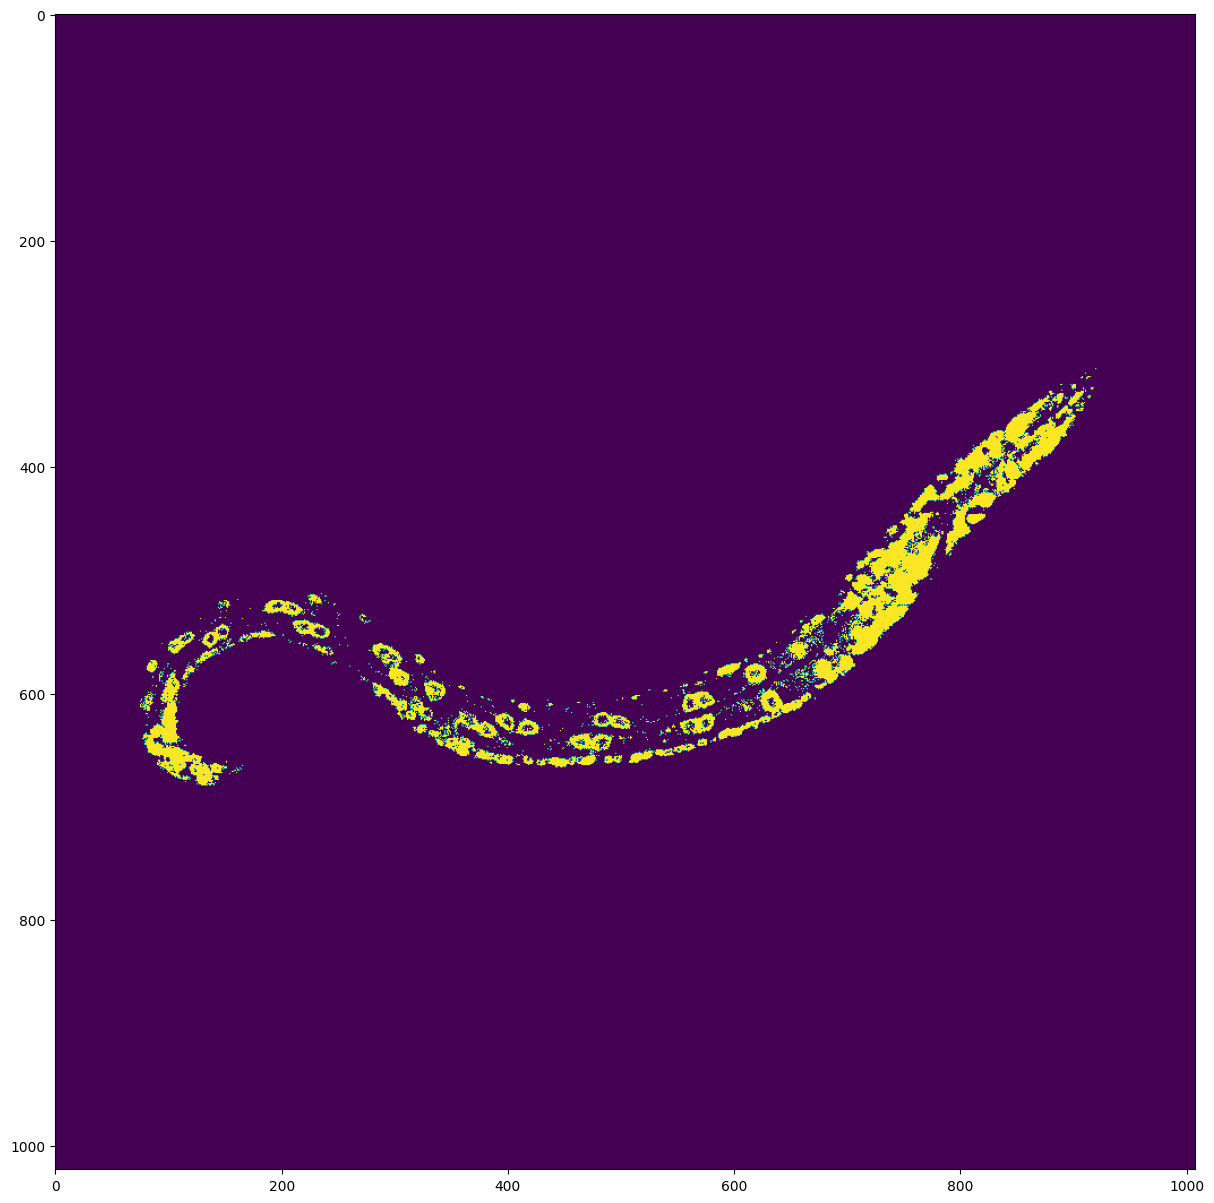

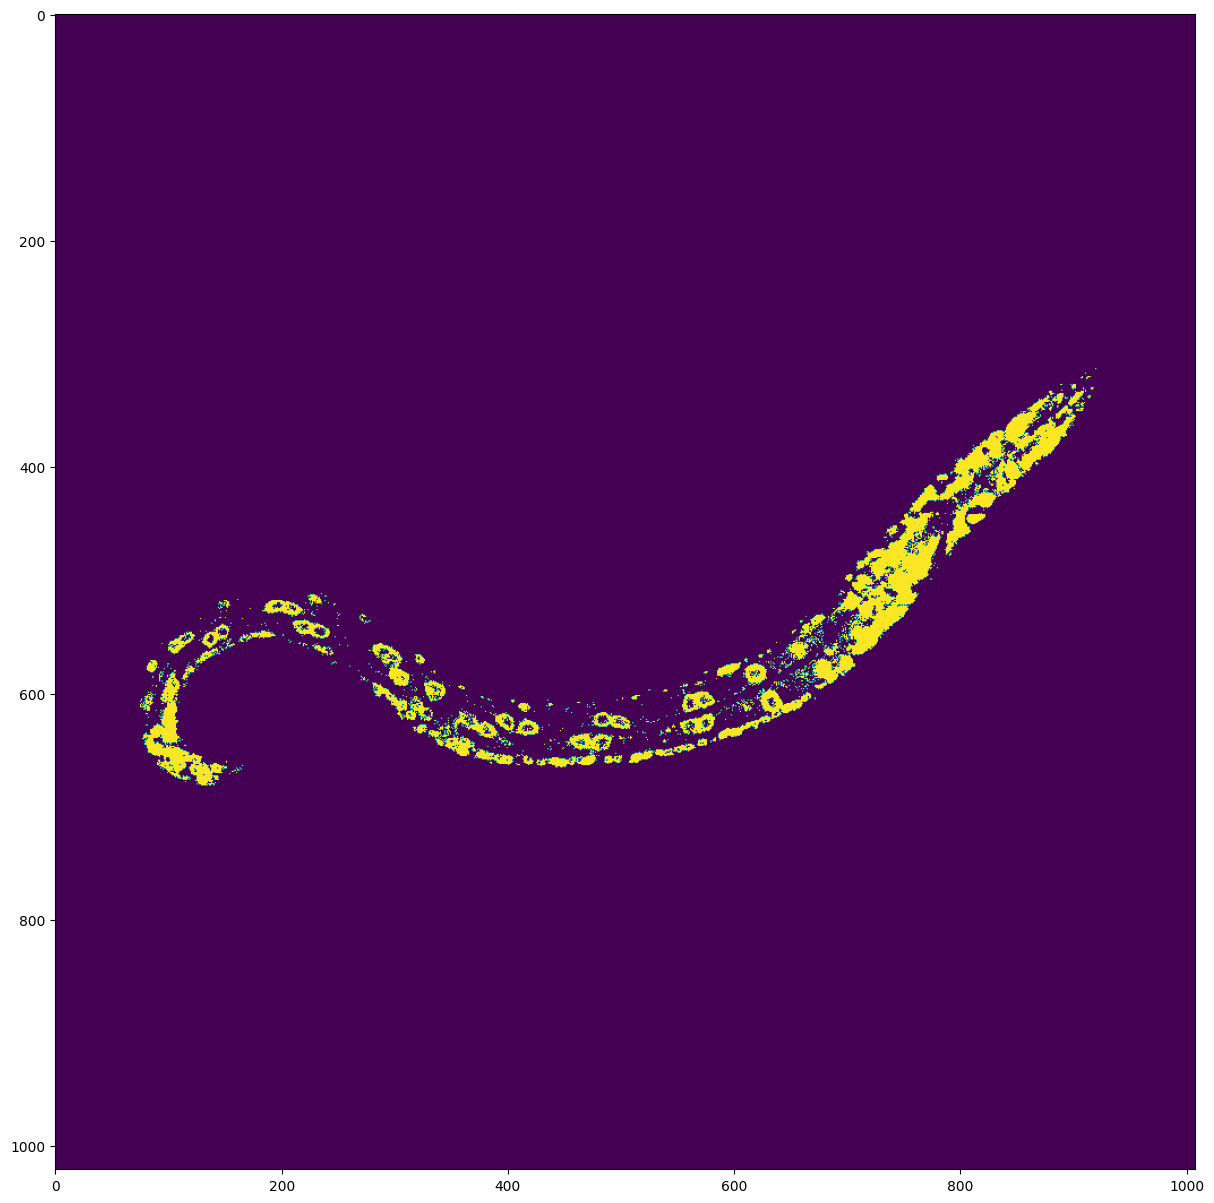

In [24]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img)
binary = img > thresh

plt.imshow(binary)
plt.show()

thresh = threshold_otsu(normalize(img))
binary = normalize(img) > thresh

plt.imshow(binary)
plt.show()
